In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# PRN:230940141009
# Name:Kartik Bhaskar Narayane

# Assignment no :5

# EDA on titanic

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from collections import Counter


In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Question:
* What did you do too address missing values?
* What is your interpretation of various columns?

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'titanic.csv'))
data_df.head()

pclass                                             name     sex      age  \
0       1                    Allen, Miss. Elisabeth Walton  female  29.0000   
1       1                   Allison, Master. Hudson Trevor    male   0.9167   
2       1                     Allison, Miss. Helen Loraine  female   2.0000   
3       1             Allison, Mr. Hudson Joshua Creighton    male  30.0000   
4       1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000   

   sibsp  parch  ticket      fare    cabin embarked  survived  
0      0      0   24160  211.3375       B5        S         1  
1      1      2  113781  151.5500  C22 C26        S         1  
2      1      2  113781  151.5500  C22 C26        S         0  
3      1      2  113781  151.5500  C22 C26        S         0  
4      1      2  113781  151.5500  C22 C26        S         0

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float64
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  1309 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


In [9]:
for col in data_df.columns:
    print(f'column.{col}:{data_df[col].unique()}')

column.pclass:[1 2 3]
column.name:['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo']
column.sex:['female' 'male']
column.age:[29.      0.9167  2.     30.     25.     48.     63.     39.     53.
 71.     47.     18.     24.     26.     80.         nan 50.     32.
 36.     37.     42.     19.     35.     28.     45.     40.     58.
 22.     41.     44.     59.     60.     33.     17.     11.     14.
 49.     76.     46.     27.     64.     55.     70.     38.     51.
 31.      4.     54.     23.     43.     52.     16.     32.5    21.
 15.     65.     28.5    45.5    56.     13.     61.     34.      6.
 57.     62.     67.      1.     12.     20.      0.8333  8.      0.6667
  7.      3.     36.5    18.5     5.     66.      9.      0.75   70.5
 22.5     0.3333  0.1667 40.5    10.     23.5    34.5    20.5    30.5
 55.5    38.5    14.5    24.5    60.5    74.      0.416

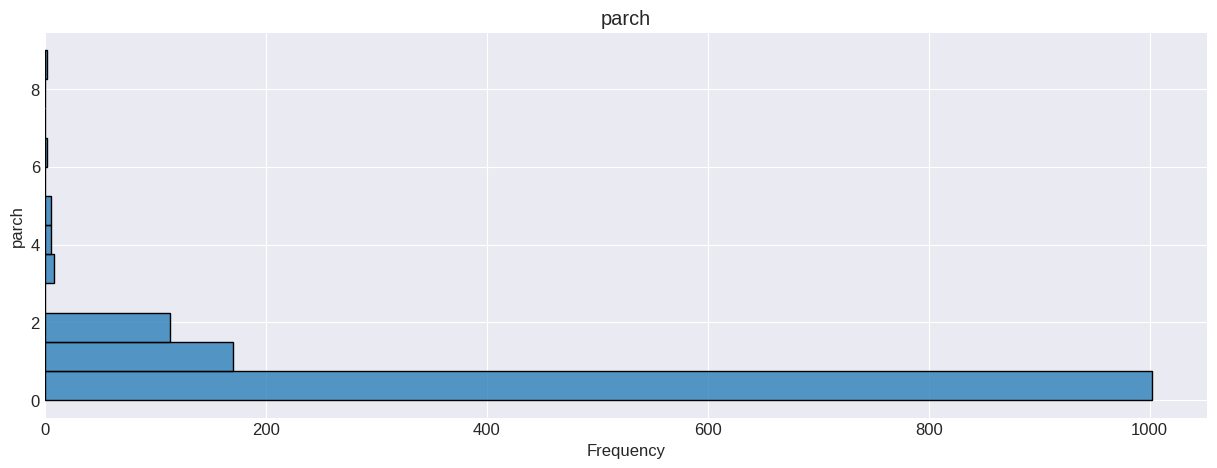

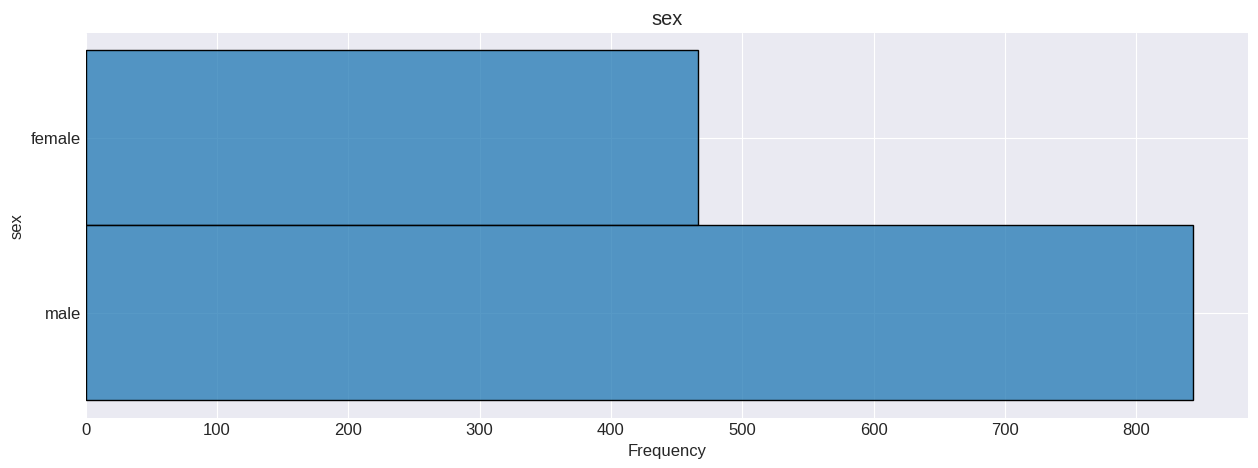

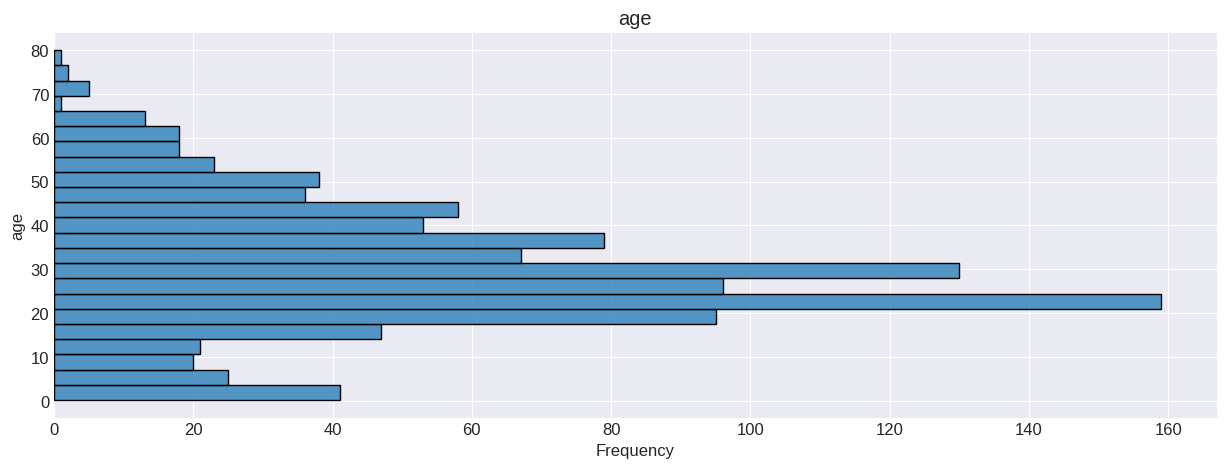

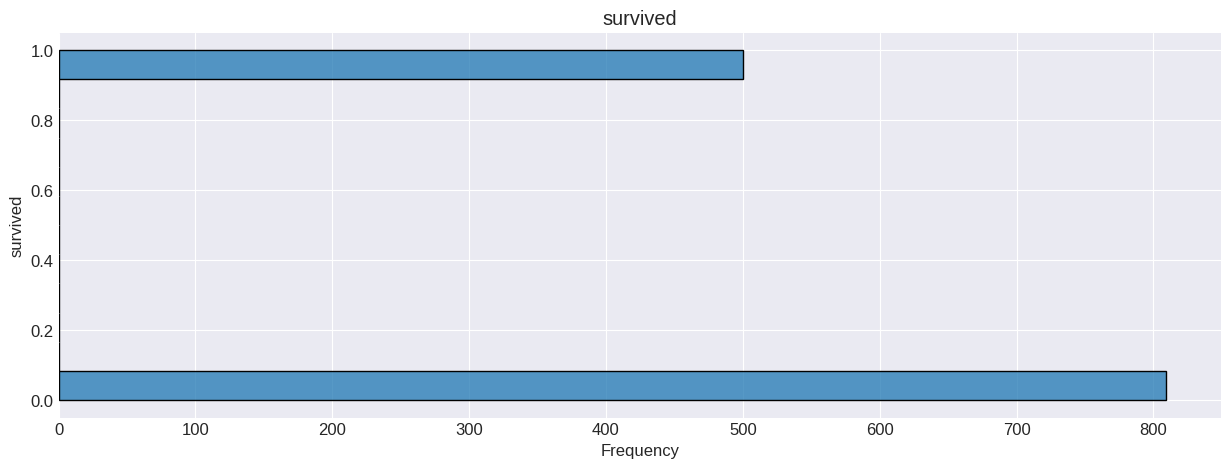

In [10]:
cat_cols = ['parch', 
            'sex', 'age', 
            'survived']

for count, col in enumerate(cat_cols):
                           
    fig, ax = plt.subplots()
    
    colCount = data_df[col].value_counts()
        
    ax.set_title(col)
    
    ax.set_xlabel('Frequency')
    
    #sns.countplot(data_df, y = col, ax = ax)
    sns.histplot(data_df, y = col, ax = ax)

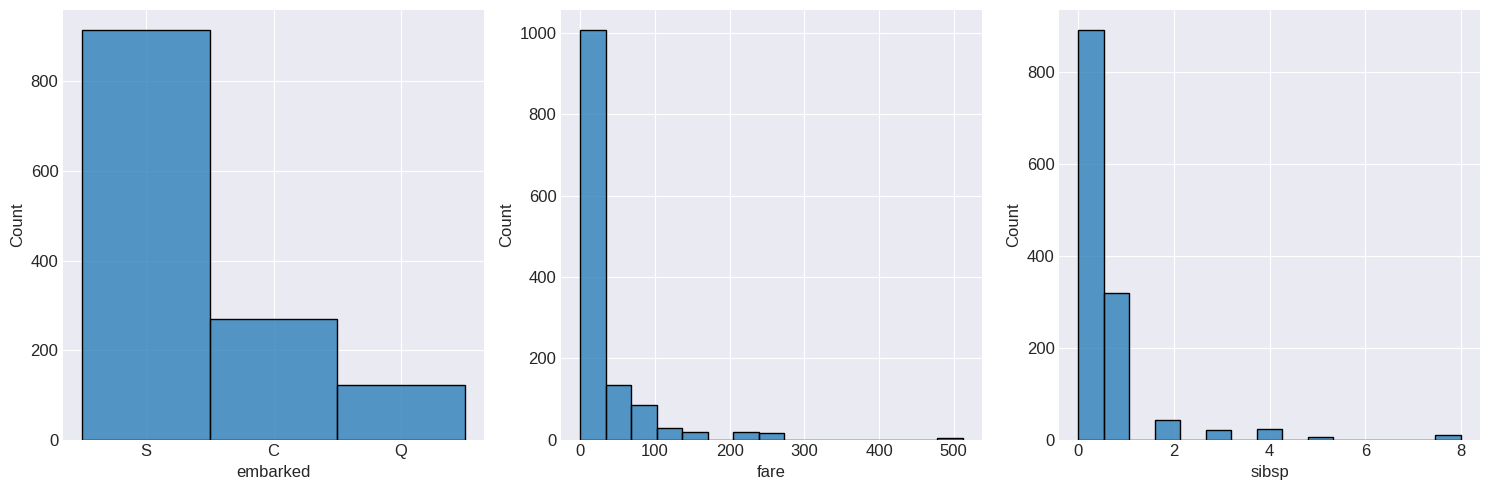

In [11]:
num_cols = ['embarked','fare','sibsp']
fig, axes = plt.subplots(1,3)

for count, col in enumerate(num_cols):
    
    ax =axes[count]
    
    sns.histplot(data_df, x = col, ax = ax, bins = 15)

plt.tight_layout()

In [12]:
data_df[['sex', 'survived']].groupby(['sex'], as_index = False).mean()

sex  survived
0  female  0.727468
1    male  0.190985

In [13]:
data_df[['sex', 'fare']].groupby(['sex'], as_index = False).mean()

sex       fare
0  female  46.198097
1    male  26.154601

In [14]:
data_df[['sex', 'pclass']].groupby(['sex'], as_index = False).mean()

sex    pclass
0  female  2.154506
1    male  2.372479

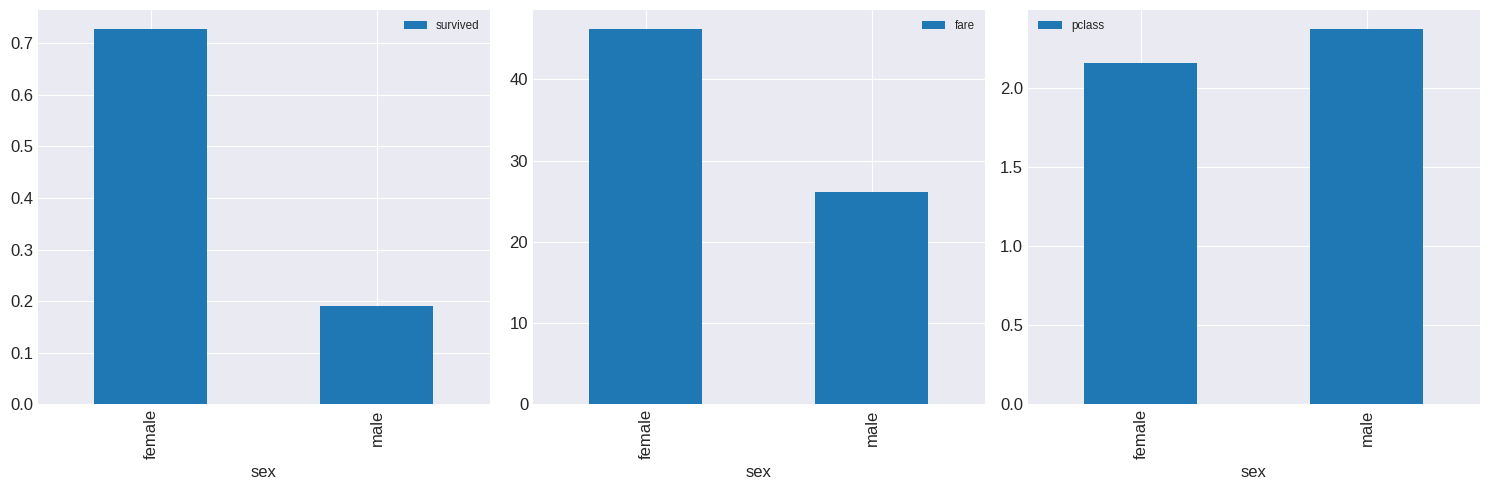

In [15]:
fig, axes = plt.subplots(1,3)

data_df[['sex', 'survived']].groupby(['sex']).mean().plot(kind = 'bar', ax = axes[0])

data_df[['sex', 'fare']].groupby(['sex']).mean().plot(kind = 'bar', ax = axes[1])

data_df[['sex', 'pclass']].groupby(['sex']).mean().plot(kind = 'bar', ax = axes[2])
    
plt.tight_layout()

In [16]:
col = 'embarked'
data_df[[col, 'parch']].groupby([col], as_index = False).mean()

embarked     parch
0        C  0.370370
1        Q  0.113821
2        S  0.426696

In [17]:
data_df[[col, 'sibsp']].groupby([col], as_index = False).mean()

embarked     sibsp
0        C  0.400000
1        Q  0.341463
2        S  0.550328

In [18]:
data_df[[col, 'survived']].groupby([col], as_index = False).mean()

embarked  survived
0        C  0.555556
1        Q  0.357724
2        S  0.332604

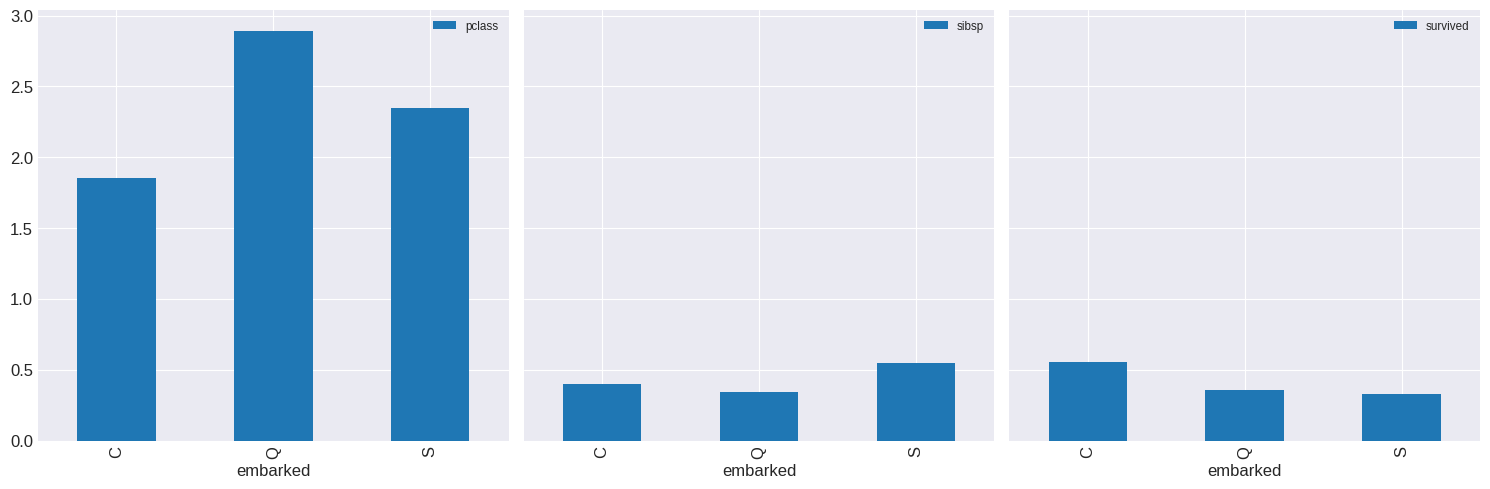

In [19]:
fig, axes = plt.subplots(1,3, sharey=True)
col = 'embarked'
data_df[[col, 'pclass']].groupby([col]).mean().plot(kind = 'bar', ax = axes[0])

data_df[[col, 'sibsp']].groupby([col]).mean().plot(kind = 'bar', ax = axes[1])

data_df[[col, 'survived']].groupby([col]).mean().plot(kind = 'bar', ax = axes[2])

plt.tight_layout()

In [20]:
col = 'cabin'
display(data_df[[col, 'pclass']].groupby([col], as_index = False).mean())
display(data_df[[col, 'sibsp']].groupby([col], as_index = False).mean())
display(data_df[[col, 'survived']].groupby([col], as_index = False).mean())

cabin  pclass
0     A10     1.0
1     A11     1.0
2     A14     1.0
3     A16     1.0
4     A18     1.0
..    ...     ...
181   F33     2.0
182   F38     3.0
183    F4     2.0
184    G6     3.0
185     T     1.0

[186 rows x 2 columns]

cabin  sibsp
0     A10    0.0
1     A11    0.0
2     A14    0.0
3     A16    1.0
4     A18    0.0
..    ...    ...
181   F33    0.0
182   F38    0.0
183    F4    1.5
184    G6    0.6
185     T    0.0

[186 rows x 2 columns]

cabin  survived
0     A10       0.0
1     A11       1.0
2     A14       0.0
3     A16       1.0
4     A18       0.0
..    ...       ...
181   F33       1.0
182   F38       0.0
183    F4       1.0
184    G6       0.6
185     T       0.0

[186 rows x 2 columns]

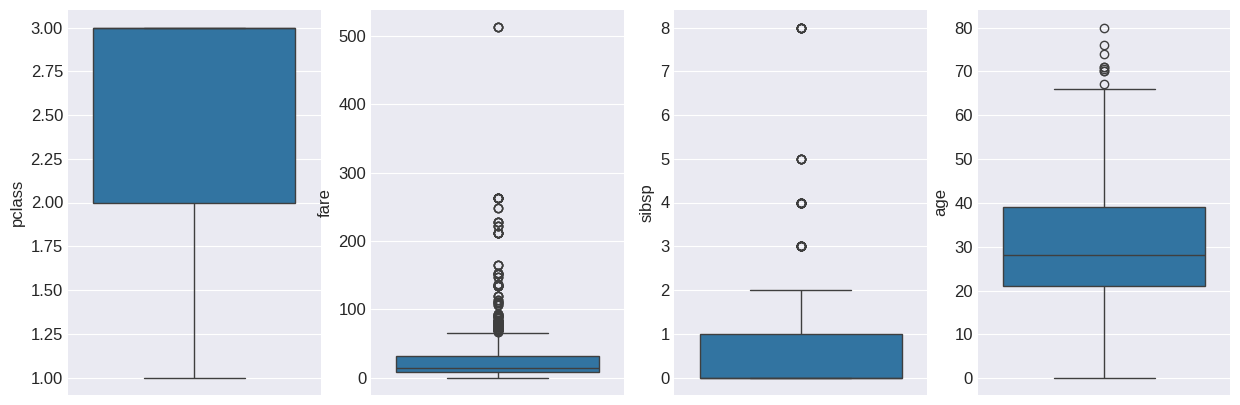

In [21]:
fig, axes = plt.subplots(1,4)

sns.boxplot(y="pclass", data=data_df, ax = axes[0])
sns.boxplot(y="fare", data=data_df, ax = axes[1])
sns.boxplot(y="sibsp", data=data_df, ax = axes[2])
sns.boxplot(y="age", data=data_df, ax = axes[3])

# Show the plot
plt.show()

In [22]:
# 1st quartile
Q1 = np.percentile(data_df['sibsp'],25)

# 3rd quartile
Q3 = np.percentile(data_df['sibsp'],75)

In [23]:
outlier_dis = (Q3-Q1) * 1.5
outlier_dis

1.5

In [24]:
outliers = data_df[data_df['sibsp'] < Q1 - outlier_dis].index
outliers

Index([], dtype='int64')

In [25]:
outlier_list = []
outlier_list.extend( data_df[data_df['pclass'] < Q1 - outlier_dis].index )
outlier_list.extend( data_df[data_df['fare'] < Q1 - outlier_dis].index )
outlier_list.extend( data_df[data_df['sibsp'] < Q1 - outlier_dis].index )

In [26]:
outlier_count = Counter(outlier_list)
outlier_count

Counter()

In [27]:
data_df['overall'] = (data_df['pclass'] + data_df['fare'] + data_df['sibsp']) /3.

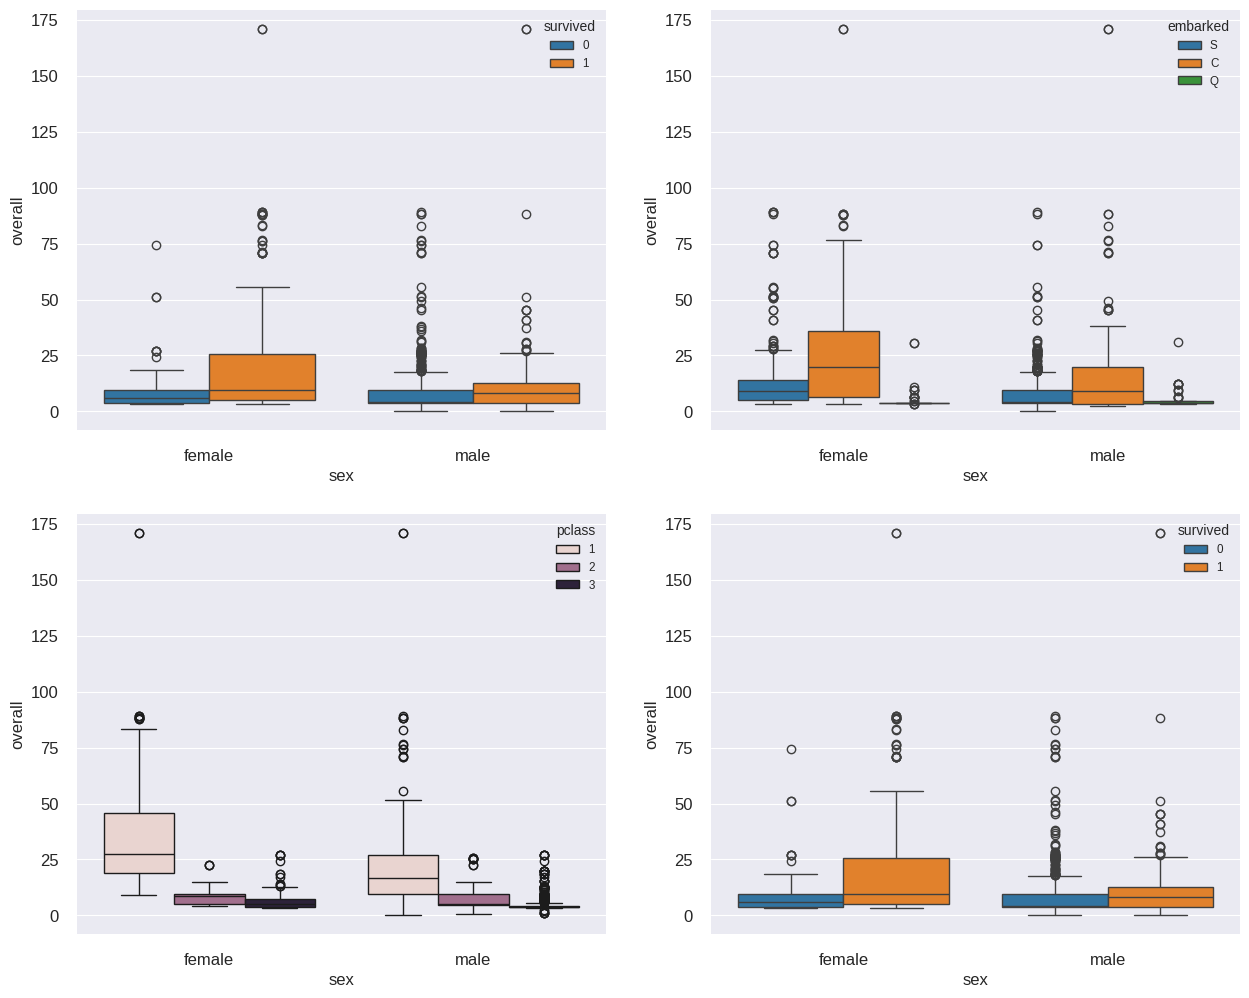

In [31]:
fig = plt.figure(figsize = (15, 12))

# Add the first set of axes (subplot 1)
ax = fig.add_subplot(221)  # 2 row, 2 columns, subplot 1

# plot on ax
sns.boxplot(x='sex', 
            y='overall', 
            hue='survived', 
            data=data_df, 
            ax=ax)

# Add the first set of axes (subplot 2)
ax = fig.add_subplot(222)  # 2 row, 2 columns, subplot 2

# plot on ax
sns.boxplot(x='sex', 
            y='overall', 
            hue='embarked', 
            data=data_df, 
            ax=ax)

# Add the first set of axes (subplot 3)
ax = fig.add_subplot(223)  # 2 row, 2 columns, subplot 3

# plot on ax
sns.boxplot(x='sex', 
            y='overall', 
            hue='pclass', 
            data=data_df, 
            ax=ax)

# Add the first set of axes (subplot 3)
ax = fig.add_subplot(224)  # 2 row, 2 columns, subplot 4

# plot on ax
sns.boxplot(x='sex', 
            y='overall', 
            hue='survived', 
            data=data_df, 
            ax=ax)

sns.despine(offset=10, trim=True)

plt.show()

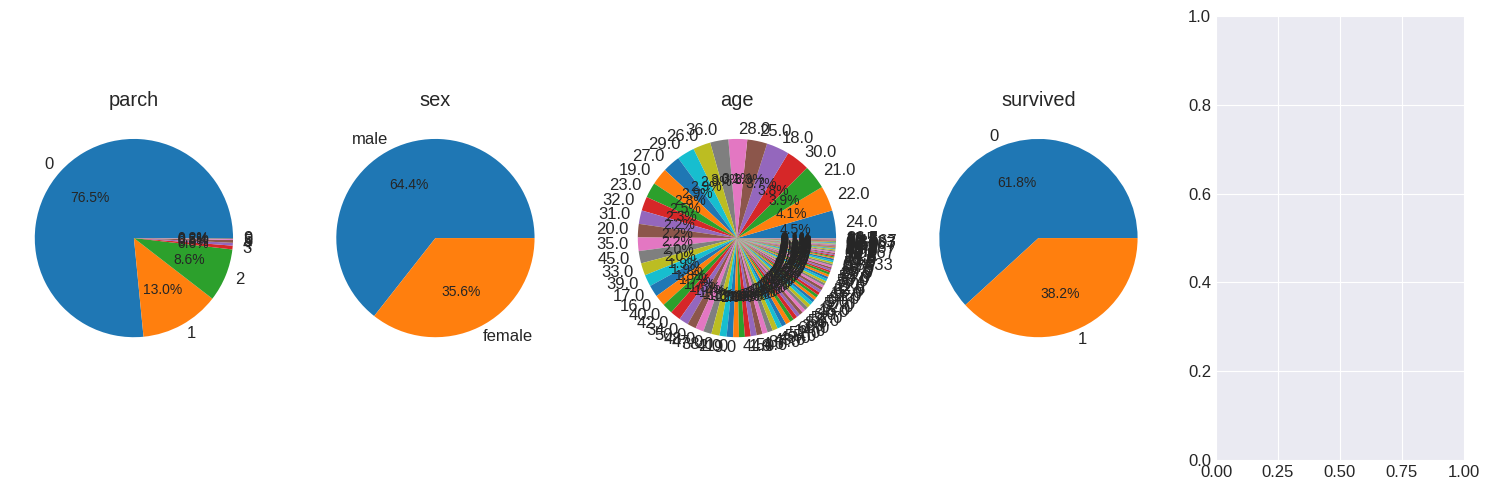

In [32]:
fig, axes = plt.subplots(1,5)

for count, col in enumerate(cat_cols):
    ax = axes[count]
    data_df[col].value_counts().plot.pie (ax = ax , autopct='%1.1f%%')
    ax.set_title(col)
    ax.set_ylabel('')
plt.tight_layout()

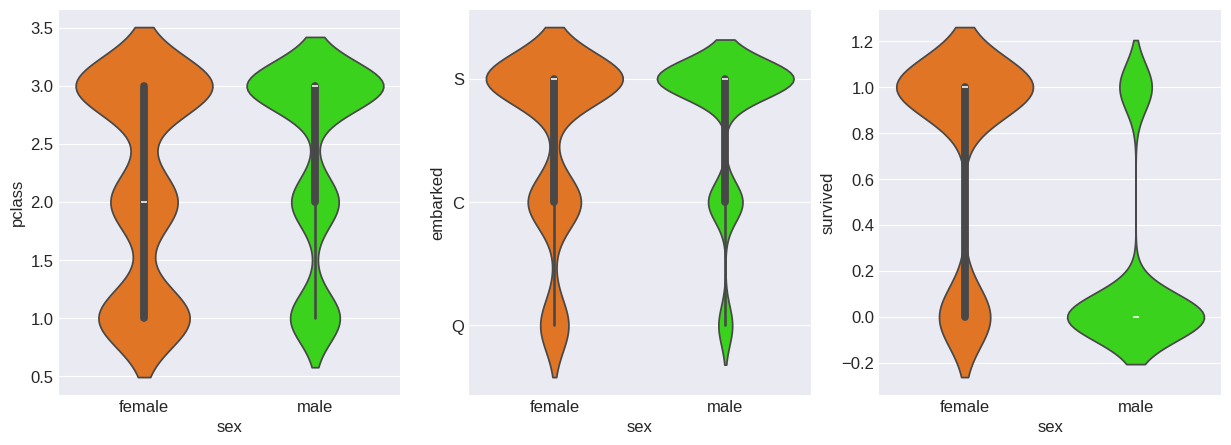

In [33]:
fig, axes = plt.subplots(1, 3)

ax = axes[0]
sns.violinplot(x = 'sex', 
               y = 'pclass', 
               hue = 'sex', 
               data = data_df, 
               palette="gist_ncar_r", 
               ax = ax) 

ax = axes[1]
sns.violinplot(x = 'sex', 
               y = 'embarked', 
               hue = 'sex',
               data = data_df, 
               palette="gist_ncar_r", 
               ax = ax)

ax = axes[2]
sns.violinplot(x = 'sex',
               y = 'survived', 
               hue = 'sex', 
               data = data_df, 
               palette="gist_ncar_r", 
               ax = ax);

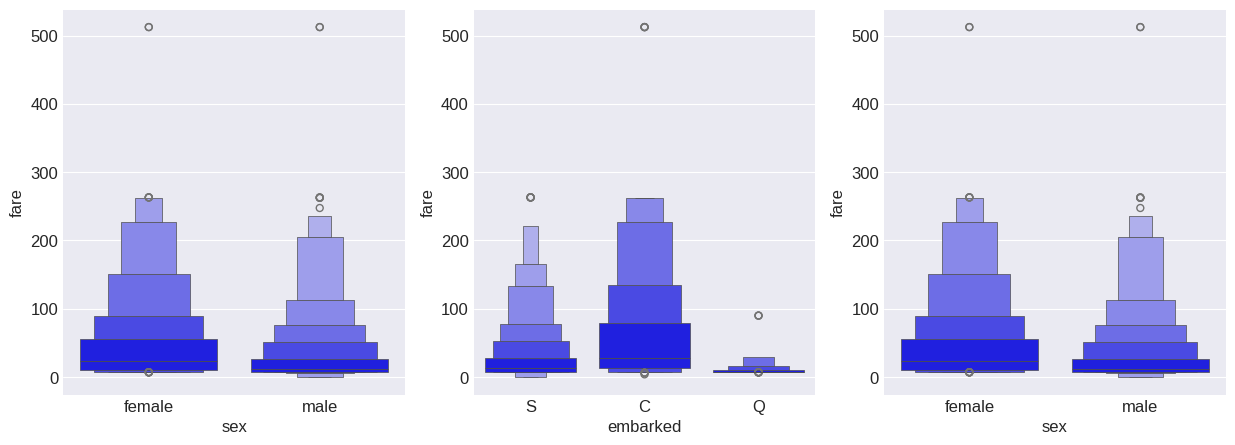

In [39]:
fig, axes = plt.subplots(1, 3)

ax = axes[0]
sns.boxenplot(x=data_df['sex'], y=data_df['fare'],
              color="b", 
              width_method = "linear", 
              data=data_df, 
              ax = ax)

ax = axes[1]
sns.boxenplot(x=data_df['embarked'], y=data_df['fare'],
              color="b", 
              width_method = "linear", 
              data=data_df, 
              ax = ax)

ax = axes[2]
sns.boxenplot(x=data_df['sex'], 
              y=data_df['fare'],
              color="b", 
              width_method = "linear", 
              data=data_df,
              ax = ax);

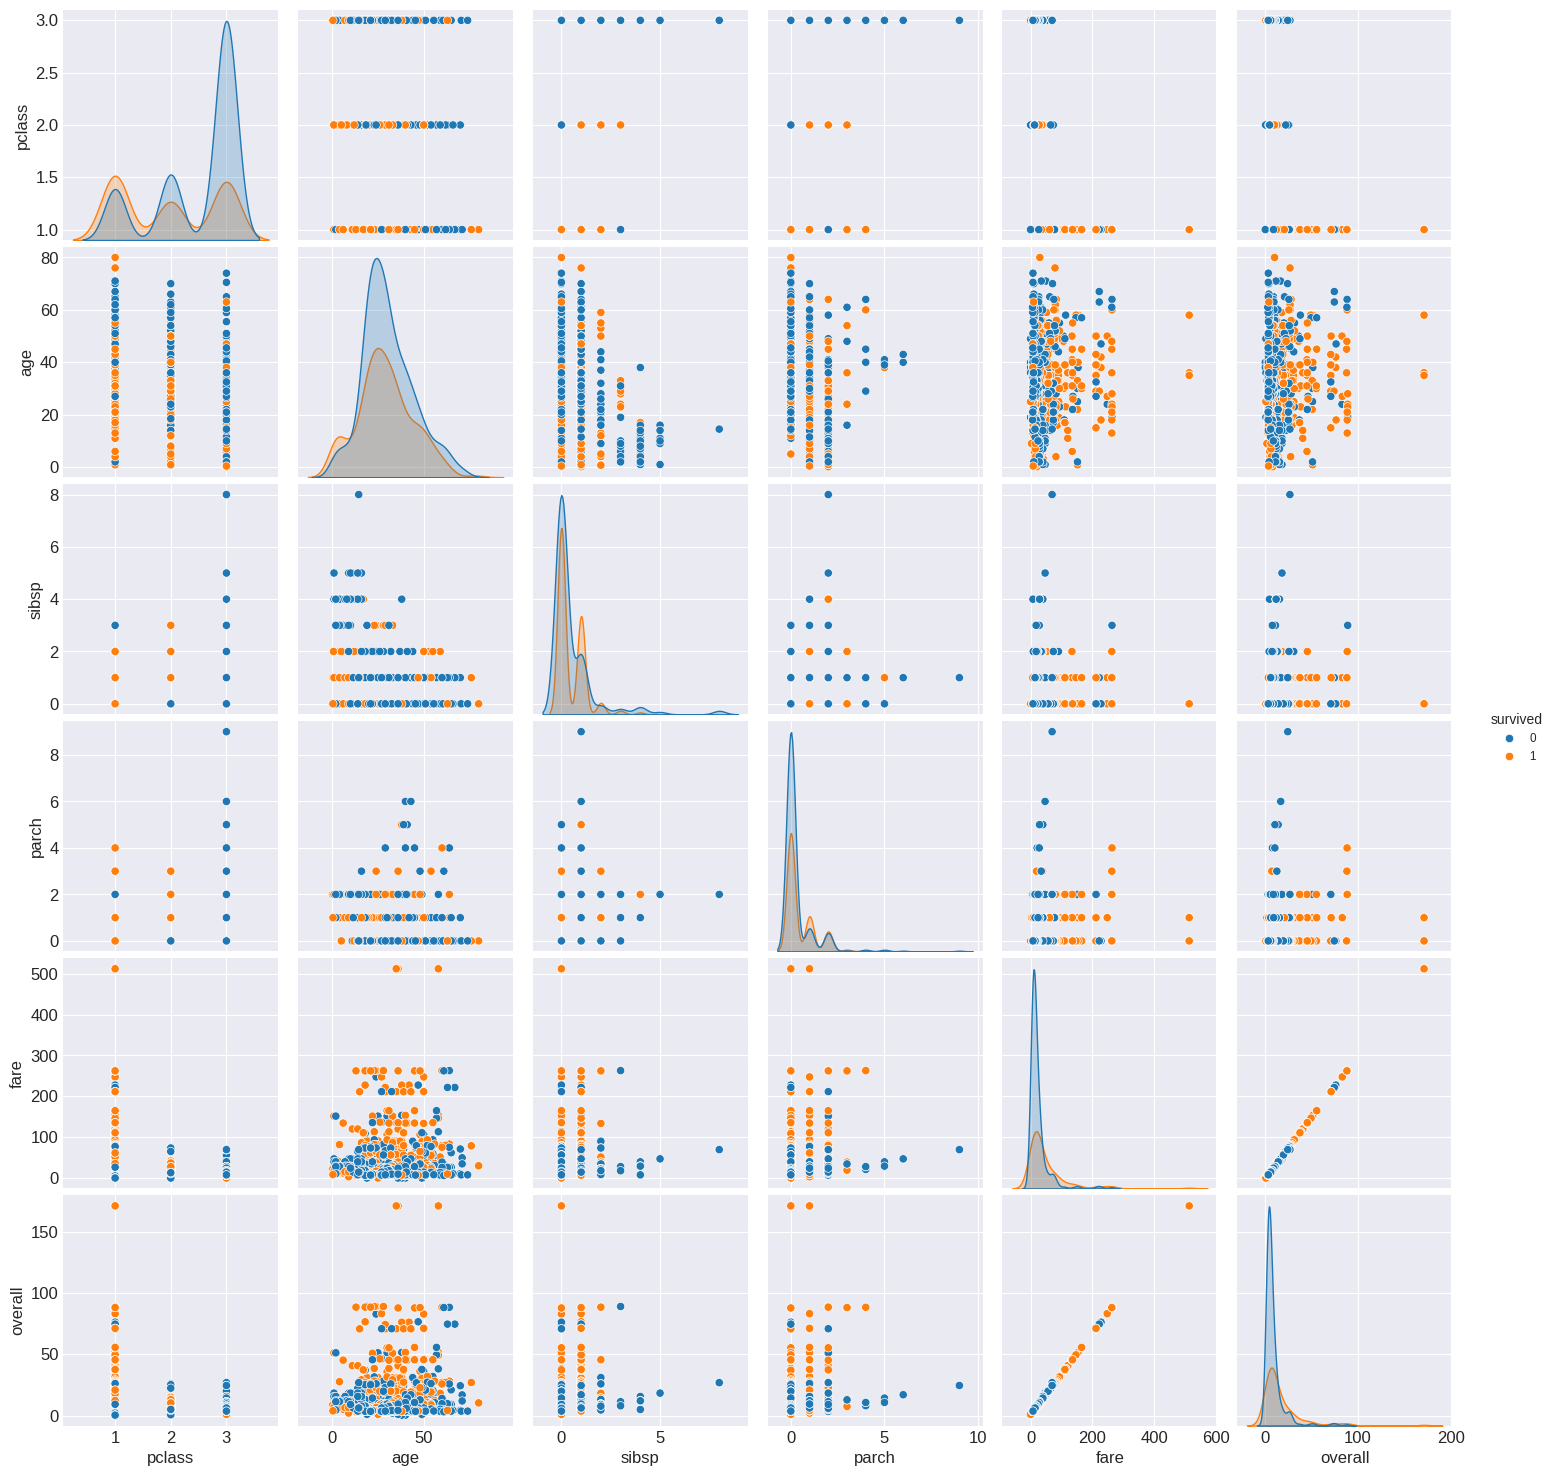

In [40]:
sns.pairplot(data_df, hue  ='survived')

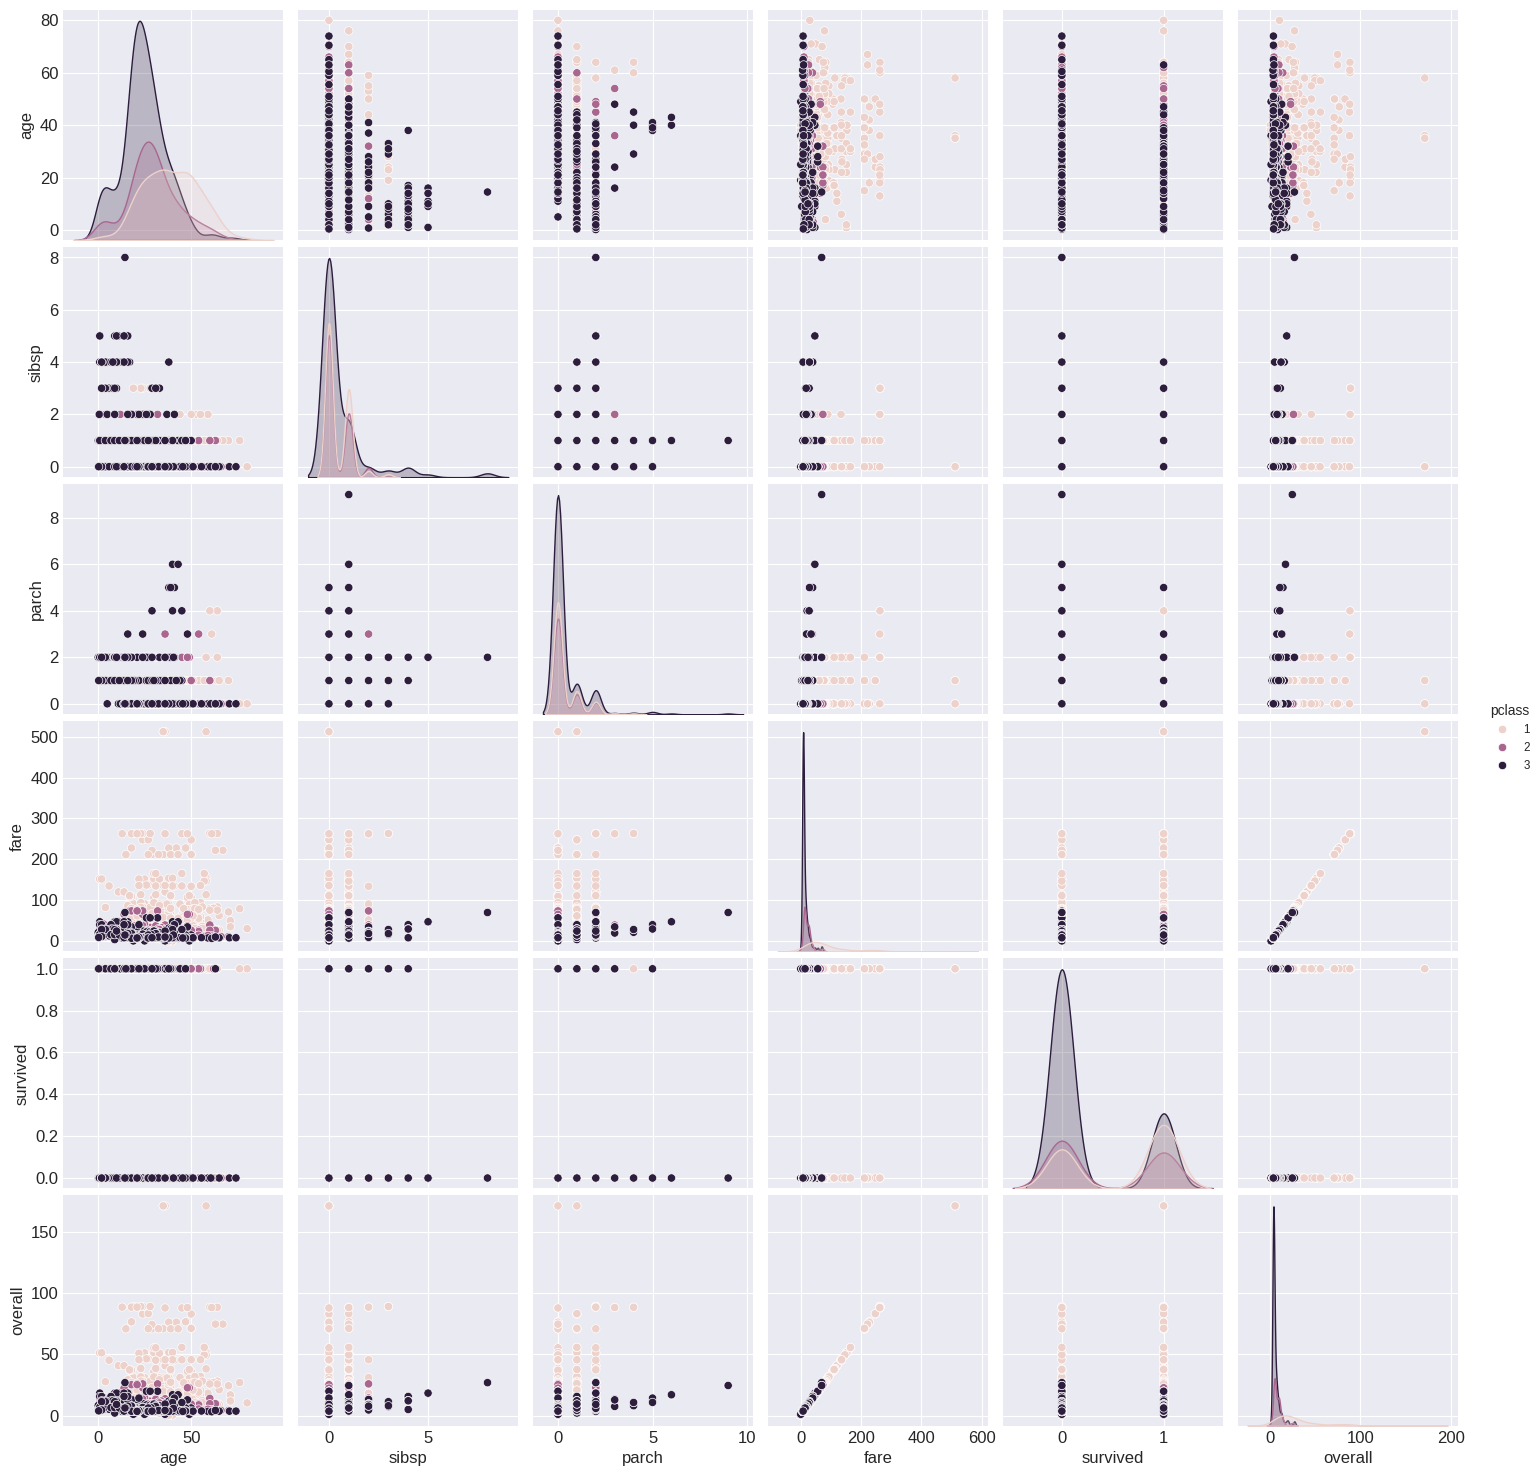

In [41]:
sns.pairplot(data_df, hue  ='pclass')

/tmp/ipykernel_93203/3405258131.py:1: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.histplot(


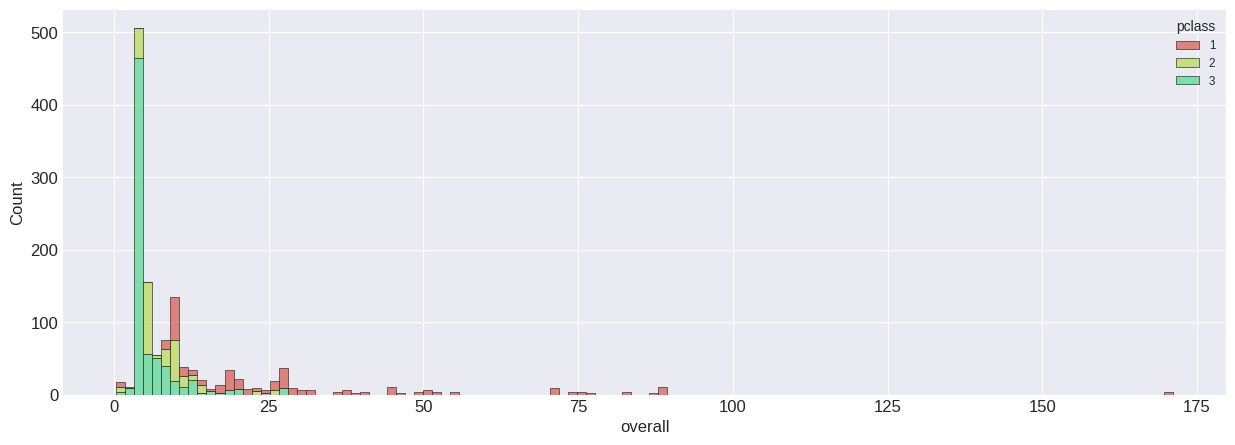

In [42]:
sns.histplot(
    data_df,
    x="overall", hue="pclass",
    multiple="stack",
    palette=sns.color_palette("hls", 5),
    edgecolor=".2",
    linewidth=.5,
    #log_scale=True,
);